In [83]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
#from chainer import serializers
import cPickle as pickle # hdf5のインストールがめんどいからpickleでシリアライズ

In [2]:
# mnistをDL
mnist = fetch_mldata("MNIST original", data_home="./data")

(70000L, 784L)


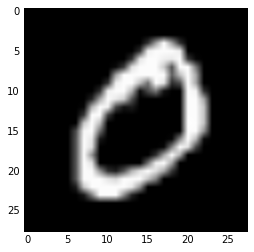

In [3]:
# データをロード
x = mnist.data
y = mnist.target
x = x.astype(np.float32)
y = y.astype(np.int32)

# 内容を確認
print x.shape # (700000, 784) => 28x28(784)の画像が70000枚
plt.imshow(x[0].reshape((28,28)), cmap=plt.cm.gray) # (28, 28)に変換してグレースケールで表示
plt.show()

In [4]:
# 輝度を揃える
x /= x.max()

In [5]:
#データを「学習データ:テストデータ=9:1」に分ける
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1)

In [7]:
# (データ数, チャネル数(色数), 縦, 横)の形式にする
x_train=x_train.reshape((x_train.shape[0], 1, 28, 28))
x_test=x_test.reshape((x_test.shape[0], 1, 28, 28))

In [8]:
# 実験の各パラメータ
batchsize = 100 # バッチサイズ。何個のデータをまとめて学習するか
epoch = 20 # エポック数。訓練をデータセット何週分するか
n_units = 100 # MLPの中間層の数。

In [57]:
# 訓練するモデル
# chainerのexampleから引っ張ってきた

class MnistMLP(chainer.Chain):
    def __init__(self, n_units):
        super(MnistMLP, self).__init__(
            l1=L.Linear(784, n_units),
            l2=L.Linear(n_units, n_units),
            l3=L.Linear(n_units, 10),
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [49]:
model = L.Classifier(MnistMLP(1000))

In [50]:
# 最適化アルゴリズムを選択
# Adamを使う
optimizer = optimizers.Adam()
optimizer.setup(model)

In [51]:
def train(model, optimizer, x_data, y_data, batchsize=10):
    N = x_data.shape[0] # 学習データ数(63000)
    perm = np.random.permutation(N) # 学習する順番をランダムに入れ替え
    
    sum_accuracy = 0    # 累計正答率
    sum_loss = 0        # 累計誤差
    start = time.time() # 開始時刻
    
    # batchsize個ずつ学習
    for i in tqdm(range(0, N, batchsize)):
        x = chainer.Variable(np.asarray(x_data[i:i + batchsize]))
        t = chainer.Variable(np.asarray(y_data[i:i + batchsize]))
        
        # パラメータの更新(学習)
        optimizer.update(model, x, t)
        
        sum_loss += float(model.loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
        
    end = time.time() # 終了時刻
    elapsed_time = end - start
    throughput = N / elapsed_time # 単位時間当たりの作業量
    print("train mean loss={}, accuracy={}, throughput={} image/sec".format(
        sum_loss / N, sum_accuracy / N, throughput))

In [52]:
def evaluate(model, x_data, y_data, batchsize=10):
    N = x_data.shape[0] # テストデータ数(7000)
    perm = np.random.permutation(N) # 学習する順番をランダムに入れ替え
    
    sum_accuracy = 0    # 累計正答率
    sum_loss = 0        # 累計誤差
    
    # batchsize個ずつ評価
    for i in tqdm(range(0, N, batchsize)):
        # 評価の時はvolatile
        x = chainer.Variable(np.asarray(x_data[i:i + batchsize]),
                             volatile="on")
        t = chainer.Variable(np.asarray(y_data[i:i + batchsize]),
                             volatile="on")
        
        # 評価
        loss = model(x, t)
        sum_loss += float(loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
        
    print("test mean loss={}, accuracy={}".format(
        sum_loss / N, sum_accuracy / N))

In [53]:
n_epoch = 10 # 学習回数(学習データを何周するか)
for epoch in range(1, n_epoch + 1):
    print("epoch", epoch)
    
    # 訓練
    train(model, optimizer, x_train, y_train, batchsize=100)
    
    # 評価
    evaluate(model, x_test, y_test, batchsize=100)

  0%|▏                                                         | 2/630 [00:00<00:44, 13.99it/s]

('epoch', 1)


 16%|████████▉                                                | 11/70 [00:00<00:00, 100.92it/s]

train mean loss=0.186727751153, accuracy=0.944079367994, throughput=1415.34866735 image/sec


  0%|▏                                                         | 2/630 [00:00<00:44, 14.18it/s]

test mean loss=0.0778330597494, accuracy=0.975285727637
('epoch', 2)


 14%|████████▎                                                 | 10/70 [00:00<00:00, 97.09it/s]

train mean loss=0.0701826661818, accuracy=0.978238105395, throughput=1307.35230327 image/sec


  0%|▏                                                         | 2/630 [00:00<00:45, 13.70it/s]

test mean loss=0.0719178480894, accuracy=0.977428586142
('epoch', 3)


 30%|█████████████████                                        | 21/70 [00:00<00:00, 100.95it/s]

train mean loss=0.0417838281826, accuracy=0.986603184352, throughput=1258.21333457 image/sec


  0%|▏                                                         | 2/630 [00:00<00:47, 13.33it/s]

test mean loss=0.0842518328623, accuracy=0.975714296954
('epoch', 4)


 13%|███████▌                                                   | 9/70 [00:00<00:00, 86.54it/s]

train mean loss=0.0344528395379, accuracy=0.988412708139, throughput=1276.33711779 image/sec


  0%|                                                          | 1/630 [00:00<01:04,  9.80it/s]

test mean loss=0.0912257000471, accuracy=0.976571439845
('epoch', 5)


 11%|██████▋                                                    | 8/70 [00:00<00:00, 77.67it/s]

train mean loss=0.025077717211, accuracy=0.992142863974, throughput=1270.16129276 image/sec


  0%|▏                                                         | 2/630 [00:00<00:56, 11.17it/s]

test mean loss=0.102075108979, accuracy=0.97400001032
('epoch', 6)


 10%|█████▉                                                     | 7/70 [00:00<00:00, 70.00it/s]

train mean loss=0.0219706931822, accuracy=0.992460323894, throughput=1219.77192368 image/sec


  0%|▏                                                         | 2/630 [00:00<00:53, 11.83it/s]

test mean loss=0.0902686440319, accuracy=0.97757143804
('epoch', 7)


 16%|████████▉                                                | 11/70 [00:00<00:00, 102.80it/s]

train mean loss=0.0217439381231, accuracy=0.993095243923, throughput=1191.12893017 image/sec


  0%|▏                                                         | 2/630 [00:00<00:46, 13.51it/s]

test mean loss=0.0905340332671, accuracy=0.979000010661
('epoch', 8)


 17%|█████████▊                                               | 12/70 [00:00<00:00, 114.29it/s]

train mean loss=0.0182794393601, accuracy=0.993793656429, throughput=1149.15272383 image/sec


  0%|▏                                                         | 2/630 [00:00<00:47, 13.25it/s]

test mean loss=0.0870895691216, accuracy=0.980000009707
('epoch', 9)


 14%|████████▎                                                 | 10/70 [00:00<00:00, 89.29it/s]

train mean loss=0.0147219946501, accuracy=0.994968258672, throughput=1170.93842409 image/sec


  0%|                                                          | 1/630 [00:00<01:13,  8.55it/s]

test mean loss=0.0857967589191, accuracy=0.981142867463
('epoch', 10)


 30%|█████████████████▍                                        | 21/70 [00:00<00:00, 99.39it/s]

train mean loss=0.0154247028921, accuracy=0.99514286168, throughput=1154.77674328 image/sec


test mean loss=0.0921967311438, accuracy=0.980285726275


In [28]:
# モデルを保存
with open("mnist_mlp.model", "wb") as f:
    pickle.dump(model, f)

In [30]:
# モデルをロード
with open("mnist_mlp.model", "rb") as f:
    model = pickle.load(f)

('target id', 5828)


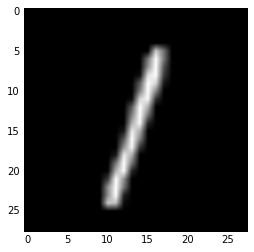

('predict label :', 1)


In [60]:
# テストしてみる
# 内容を確認
target = np.random.randint(x_test.shape[0])
print ("target id", target)
plt.imshow(x_test[target].reshape((28,28)), cmap=plt.cm.gray) # (28, 28)に変換してグレースケールで表示
plt.show()

x = chainer.Variable(np.asarray([x_test[target]]), volatile="on")
t = chainer.Variable(np.asarray([y_test[target]]), volatile="on")
a = model.predictor(x)
predict_label = np.argmax(a.data)

print ("predict label :", predict_label)

In [62]:
category_dict = dict([(x, str(x)) for x in range(10)])

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category_dict))
    plt.xticks(tick_marks, category_dict, rotation=45)
    plt.yticks(tick_marks, category_dict)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [79]:
def predict(model, x_data, batchsize=10):
    N = x_data.shape[0] # テストデータ数(7000)
    predicts = []
    # batchsize個ずつ予測
    for i in tqdm(range(0, N, batchsize)):
        # 評価の時はvolatile
        x = chainer.Variable(np.asarray(x_data[i:i + batchsize]),
                             volatile="on")
        
        # 評価
        a = model.predictor(x)
        predict_labels = np.argmax(a.data, axis=1)
        predicts.append(predict_labels)
    
    predicts = np.asarray(predicts)
    return predicts.reshape((N))

In [81]:
y_pred = predict(model, x_test, batchsize=100)

Confusion matrix, without normalization
[[686   0   0   0   0   0   6   0   0   0]
 [  1 783   0   0   1   1   0   3   1   0]
 [  4   0 687   1   1   0   0   2   3   1]
 [  0   1   4 709   0   7   0   4   8   3]
 [  0   2   0   0 693   0   1   1   0   5]
 [  1   0   0   3   1 599   5   1   3   5]
 [  0   0   0   0   7   0 664   0   0   0]
 [  1   1   1   0   0   0   0 733   0   6]
 [  7   4   0   2   2   0   2   3 652   1]
 [  2   2   0   1   8   1   1   4   2 656]]


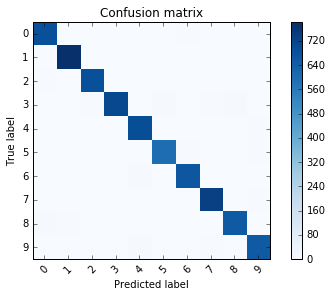

In [84]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)